Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense, Rescaling
from tensorflow.keras.regularizers import l2

## Loading the data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
train_data_path = "/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train"
test_data_path = "/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test"
data_dir_train = pathlib.Path(train_data_path)
data_dir_test = pathlib.Path(test_data_path)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create training and validation dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123
validation_split = 0.2

Use 80% of the images for training, and 20% for validation.

In [ ]:
# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
  seed=seed,
  validation_split = validation_split,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
  seed=seed,
  validation_split = validation_split,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [8]:
# List out class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

In [ ]:
class_images = {class_name: None for class_name in class_names}
for images, labels in train_ds.take(3):
    for i in range(len(images)):
      class_name = class_names[labels[i]]
      if class_images[class_name] is None:
          class_images[class_name] = images[i].numpy().astype("uint8")
      if all(image is not None for image in class_images.values()):
          break

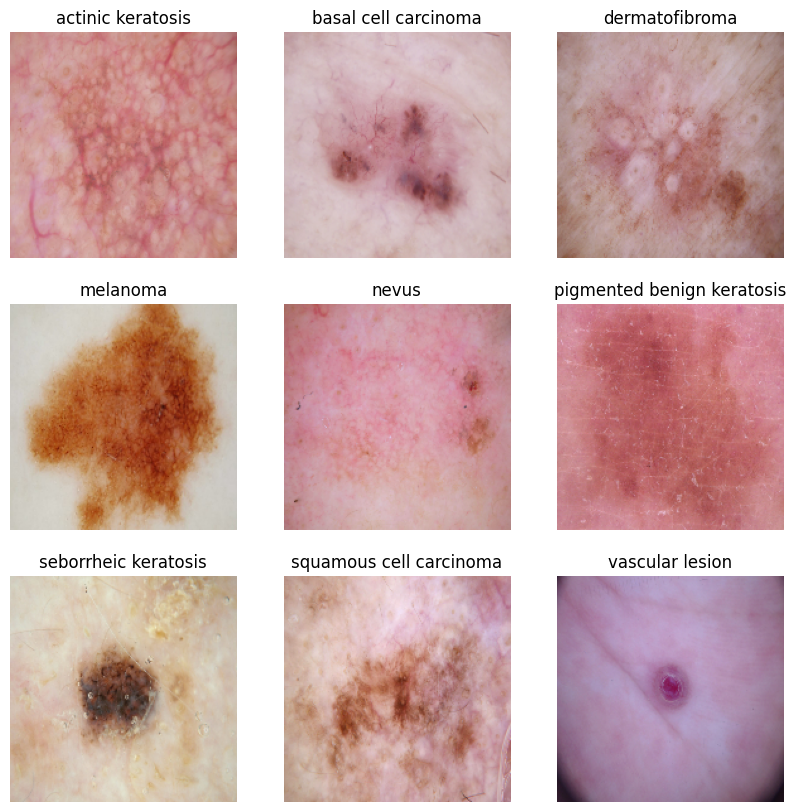

In [ ]:
plt.figure(figsize=(10, 10))
for i, class_name in enumerate(class_names):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(class_images[class_name])
    plt.title(class_name)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
def one_hot_encode(image, label):
    one_hot_label = tf.one_hot(label, depth=len(train_ds.class_names))
    return image, one_hot_label

In [10]:
## convert labels to one-hot encoded
train_ds_one_hot = train_ds.map(one_hot_encode)
val_ds_one_hot = val_ds.map(one_hot_encode)

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_one_hot = train_ds_one_hot.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_one_hot = val_ds_one_hot.cache().prefetch(buffer_size=AUTOTUNE)

### Create, compile and train the model

In [12]:
# Get the element spec of the dataset
element_spec = train_ds.element_spec
input_shape = element_spec[0].shape[1:]
num_classes = len(class_names)

print("Input shape: ", input_shape)


Input shape:  (180, 180, 3)


In [ ]:
model = Sequential()
model.add(Rescaling(scale=1/255, input_shape=input_shape))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 178, 178, 64)      0         
                                                        

In [ ]:
epochs = 20
history = model.fit(
  train_ds_one_hot,
  validation_data=val_ds_one_hot,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 464s 3s/step - loss: 27.9160 - accuracy: 0.2411 - val_loss: 17.5272 - val_accuracy: 0.1633
Epoch 2/20
56/56 [==============================] - 16s 286ms/step - loss: 12.4567 - accuracy: 0.3343 - val_loss: 19.6222 - val_accuracy: 0.2036
Epoch 3/20
56/56 [==============================] - 15s 276ms/step - loss: 11.9206 - accuracy: 0.4023 - val_loss: 16.1378 - val_accuracy: 0.1655
Epoch 4/20
56/56 [==============================] - 15s 276ms/step - loss: 11.5535 - accuracy: 0.4548 - val_loss: 16.5658 - val_accuracy: 0.3356
Epoch 5/20
56/56 [==============================] - 15s 275ms/step - loss: 11.2251 - accuracy: 0.4939 - val_loss: 16.0784 - val_accuracy: 0.2260
Epoch 6/20
56/56 [==============================] - 15s 275ms/step - loss: 10.8898 - accuracy: 0.5285 - val_loss: 14.0999 - val_accuracy: 0.3020
Epoch 7/20
56/56 [==============================] - 15s 275ms/step - loss: 10.5375 - accuracy: 0.5686 - val_loss: 12.8470 - val_accu

### Visualizing training results

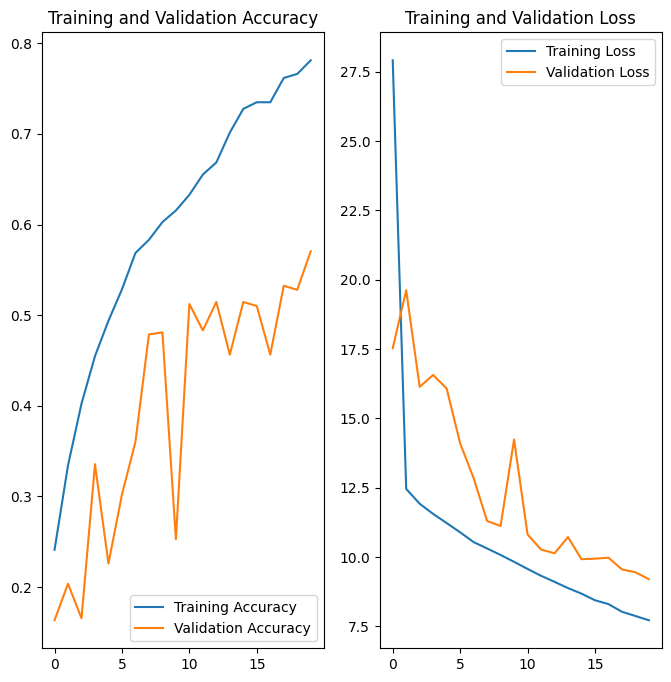

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the plots above, it can be seen that the model is overfitting because there is a large gap between the training and validation accuracies as well as the training and validation losses

## Applying augmentations

We'll now use certain preprocessing layers provided by TensorFlow. This virtually results in unlimited augmentations, as the transformations are applied randomly. This means that the network can see a slightly different image each time an image is passed through the network, which can help improve generalization.

In [13]:


data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
])

(-0.5, 179.5, 179.5, -0.5)

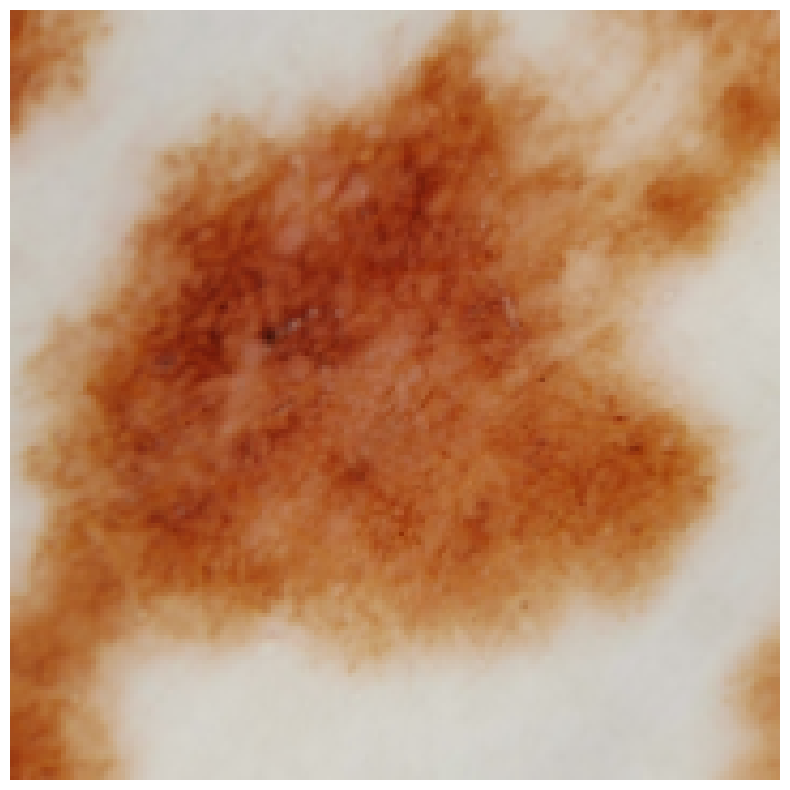

In [ ]:
# Visualise the augmentation strategy

orig_image = class_images["melanoma"]
orig_image = tf.expand_dims(orig_image, 0)
plt.figure(figsize=(10, 10))
augmented_image = data_augmentation(orig_image)
plt.imshow(augmented_image[0].numpy().astype("uint8"))
plt.axis("off")

#### Create, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()
model.add(preprocessing.Rescaling(scale=1/255, input_shape=input_shape))
model.add(data_augmentation)

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_38 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_24 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 178, 178, 64)      18496     
                                                      

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds_one_hot,
  validation_data=val_ds_one_hot,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 287ms/step - loss: 22.2871 - accuracy: 0.2076 - val_loss: 9.0822 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 14s 257ms/step - loss: 2.2459 - accuracy: 0.2556 - val_loss: 2.7932 - val_accuracy: 0.1767
Epoch 3/20
56/56 [==============================] - 15s 261ms/step - loss: 2.1005 - accuracy: 0.2779 - val_loss: 3.9410 - val_accuracy: 0.2931
Epoch 4/20
56/56 [==============================] - 15s 260ms/step - loss: 2.0001 - accuracy: 0.3069 - val_loss: 4.1669 - val_accuracy: 0.3020
Epoch 5/20
56/56 [==============================] - 14s 258ms/step - loss: 1.9456 - accuracy: 0.3309 - val_loss: 4.1895 - val_accuracy: 0.3714
Epoch 6/20
56/56 [==============================] - 14s 255ms/step - loss: 1.9246 - accuracy: 0.3265 - val_loss: 2.5986 - val_accuracy: 0.3423
Epoch 7/20
56/56 [==============================] - 14s 257ms/step - loss: 1.8692 - accuracy: 0.3365 - val_loss: 2.2533 - val_accuracy: 0.355

### Visualizing the results

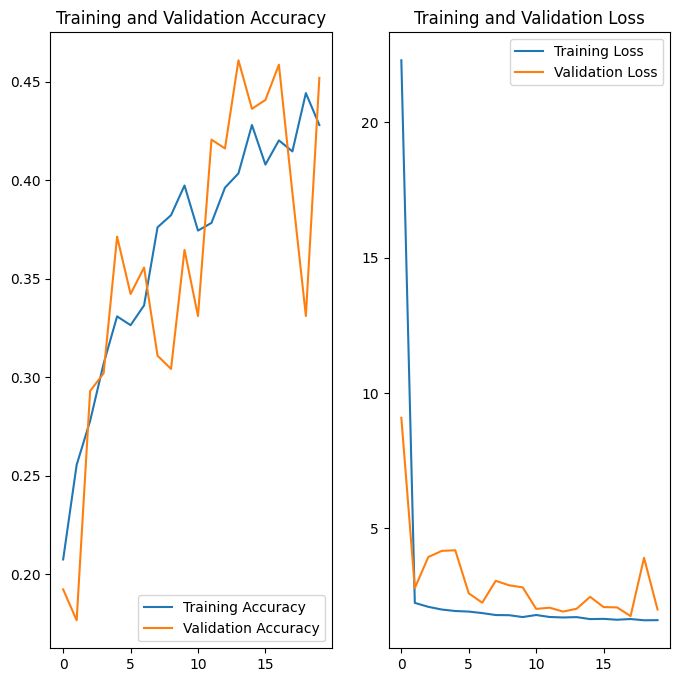

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The problem of overfitting seems to have been tackled by adding data augmentation and modifying the architecture by reducing the number of parameters and increasing the dropout ratio> However, both the training and validation accuracies are low, which indicates that the model is underfitting.

## Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
for class_name in class_names:
  total_image_count = len(list(data_dir_train.glob('*/*.jpg')))
  image_count_train = len(list(data_dir_train.glob(f'{class_name}/*.jpg')))
  print(class_name, round(image_count_train/ total_image_count, 2))

actinic keratosis 0.05
basal cell carcinoma 0.17
dermatofibroma 0.04
melanoma 0.2
nevus 0.16
pigmented benign keratosis 0.21
seborrheic keratosis 0.03
squamous cell carcinoma 0.08
vascular lesion 0.06



The seborrheic keratosis class is the least prevalent one while pigmented benign keratosis class is the most prevalent one.


## Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
data_dir_train

PosixPath('/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train')

In [ ]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF2C41C0370>: 100%|██████████| 500/500 [00:22<00:00, 22.08 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF2302C74F0>: 100%|██████████| 500/500 [00:21<00:00, 23.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF223EB5480>: 100%|██████████| 500/500 [00:23<00:00, 21.04 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF2300C84C0>: 100%|██████████| 500/500 [01:46<00:00,  4.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FF2203D3FD0>: 100%|██████████| 500/500 [01:38<00:00,  5.09 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF223E9AB30>: 100%|██████████| 500/500 [00:23<00:00, 21.73 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF2C6D24520>: 100%|██████████| 500/500 [00:49<00:00, 10.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF22076C550>: 100%|██████████| 500/500 [00:23<00:00, 21.73 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF2205597B0>: 100%|██████████| 500/500 [00:21<00:00, 23.42 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [14]:
from glob import glob

In [15]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

4500

In [16]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [17]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [18]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(lesion_list)

2239

In [19]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [20]:
dataframe_dict_old = dict(zip(path_list, lesion_list))

In [21]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-21-22a00d7d136b>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [22]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

#### Create training & validation dataset

In [23]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed,
  validation_split =validation_split,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [24]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed,
  validation_split =validation_split,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create, compile and train the model

In [14]:
model = Sequential()
model.add(preprocessing.Rescaling(scale=1/255, input_shape=input_shape))
model.add(data_augmentation)

model.add(Conv2D(64, (3, 3), padding='same'))  # Increase number of filters
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))  # Increase number of filters
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Decrease dropout rate

model.add(Conv2D(256, (3, 3), padding='same'))  # Increase number of filters
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3)))  # Increase number of filters
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Decrease dropout rate

model.add(Flatten())
model.add(Dense(512))  # Increase number of neurons
model.add(Activation('relu'))
model.add(Dropout(0.25))  # Decrease dropout rate
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 activation (Activation)     (None, 180, 180, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 128)     73856     
                                                      

In [16]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
train_ds_one_hot = train_ds.map(one_hot_encode)
val_ds_one_hot = val_ds.map(one_hot_encode)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_one_hot = train_ds_one_hot.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_one_hot = val_ds_one_hot.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
epochs = 30
history = model.fit(
  train_ds_one_hot,
  validation_data=val_ds_one_hot,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 971s 2s/step - loss: 12.1865 - accuracy: 0.2431 - val_loss: 3.0217 - val_accuracy: 0.2086
Epoch 2/30
169/169 [==============================] - 107s 631ms/step - loss: 1.7786 - accuracy: 0.3440 - val_loss: 2.2552 - val_accuracy: 0.3430
Epoch 3/30
169/169 [==============================] - 106s 628ms/step - loss: 1.6836 - accuracy: 0.3826 - val_loss: 1.6715 - val_accuracy: 0.4128
Epoch 4/30
169/169 [==============================] - 106s 630ms/step - loss: 1.5955 - accuracy: 0.3939 - val_loss: 1.4415 - val_accuracy: 0.4491
Epoch 5/30
169/169 [==============================] - 106s 628ms/step - loss: 1.5328 - accuracy: 0.4232 - val_loss: 1.4151 - val_accuracy: 0.4610
Epoch 6/30
169/169 [==============================] - 106s 627ms/step - loss: 1.4989 - accuracy: 0.4293 - val_loss: 1.4606 - val_accuracy: 0.4670
Epoch 7/30
169/169 [==============================] - 107s 631ms/step - loss: 1.4468 - accuracy: 0.4516 - val_loss: 1.5850 - v

#### Visualize the model results

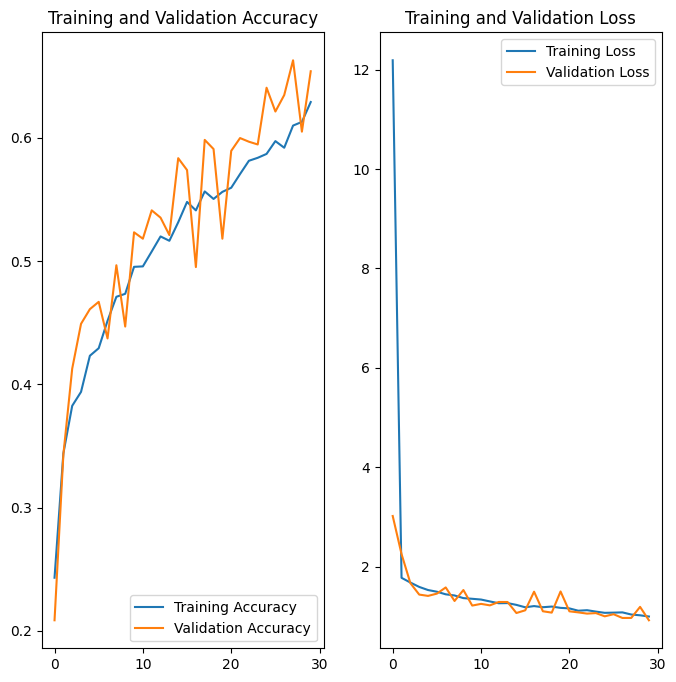

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

With modifications in the architecture as well as recitfications in the training class distributions, both the problems of underfitting and overfitting have been resolved to a certain extent. Since the losses are still decreasing and have not have not plateaued yet, it is likely that continuing the training for more than 30 epochs would have resulted in even better accuracy values.